# Finding Heavy Traffic Indicators on I-94

### Getting Home for Dinner - Finding Heavy Traffic Indicators on Minnesota I-94
In this project we'll analyze a dataset about the westbound traffic on the I-94 Interstate highway. The goal of this analysis is to determine indicators of heavy traffic on I-94, such as weather type, time of day/week/year, special events, etc, which would hopefully allow us to plan ahead and minimise time spent standing in traffic.

### The results

Data analysis has shown that traffic is affected by the time of day, whether this is a workday or not, and what month we're in. It's also affected somewhat by weather, with snow and thunderstorms being indicators of heavy traffic.

### The dataset

The dataset was made available thanks to John Hogue, and can be downloaded from the UCI Machine Learning Repository. The data is composed of hourly counts of Interstate 94 Westbound traffic volume for MN DoT ATR station 301. The station is located roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume. Let's start by reading the file and getting some initial information from it.

In [42]:
# Boilerplate code that loads the libraries and data
import pandas as pd
import numpy as np
traffic = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")

# Allow Jupyter notebook to generate plots
import matplotlib.pyplot as plt
%matplotlib inline

traffic.head()


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [43]:
traffic.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [44]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


he dataset has 48,204 rows and 9 columns, with no missing values. It's composed of 9 columns:

We do need to acknowledge the limitations of this dataset. This is data that's been collected over the course of 6 years (02/10/2012 - 30/09/2018) at one station, measuring the traffic from east to west in a single highway (Minnesota I-94). We shouldn't generalise from our analysis to the entire state, or even to the entire highway.

### Data Cleaning

The dataset doesn't require much cleaning, but there are actions we can do to make analysis easier:

Convert the date_time values from strings to datetime
Take the first holiday value from each day and apply it to the rest of the day. That is due to the fact that the 'holiday' value is only shown on midnight on each day and is 'None' for the rest of the day

In [45]:
# Convert from string to datetime
traffic['date_time'] = pd.to_datetime(traffic['date_time'])

In [46]:
# Replace the text 'None' with an actual NaN object
traffic['holiday'].replace('None', np.nan, inplace=True)

# Take the first holiday value from each day and apply it to the rest of the day
traffic['holiday'] = traffic.groupby(traffic['date_time'].dt.date)['holiday'].ffill()

# Revert to 'None', to allow looking at no-holiday traffic when grouping by values 
traffic['holiday'].replace(np.nan, 'None', inplace=True)

# Analysis
Let's have a look at the total traffic's distribution:

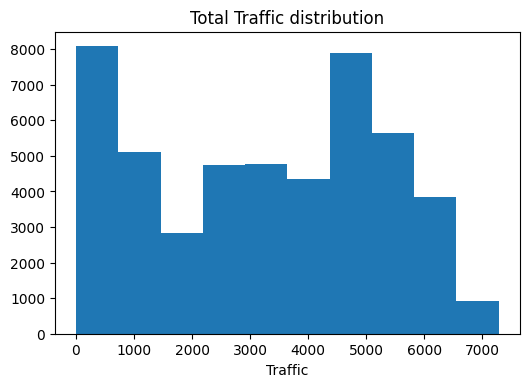

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(traffic['traffic_volume'])
plt.title("Total Traffic distribution")
plt.xlabel("Traffic")

plt.show()

In [48]:
traffic['traffic_volume'].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

The traffic's volume spans between 0 cars/hour and 7,280 cars/hour and doesn't seem to have a distinct distribution. It's got two peaks at 0-728 and 4,368-5,096 with about 1/6 of the total number of measurements in each bucket, and a mean value of ~3,260. I assume the peak at the low bucket is due to nighttime measurements, when traffic is naturally low.

## Daytime Vs. Nighttime

So let's divide our dataset into two parts - daytime (7 a.m. - 7 p.m.) and nighttime (7 p.m. - 7 a.m.) and see if we can learn something by comparing them.

In [49]:
traffic['date_time'] = pd.to_datetime(traffic['date_time'])
traffic_daytime = traffic.copy()[(traffic['date_time'].dt.hour >= 7) & (traffic['date_time'].dt.hour < 19)]
traffic_nighttime = traffic.copy()[(traffic['date_time'].dt.hour >= 19) | (traffic['date_time'].dt.hour < 7)]

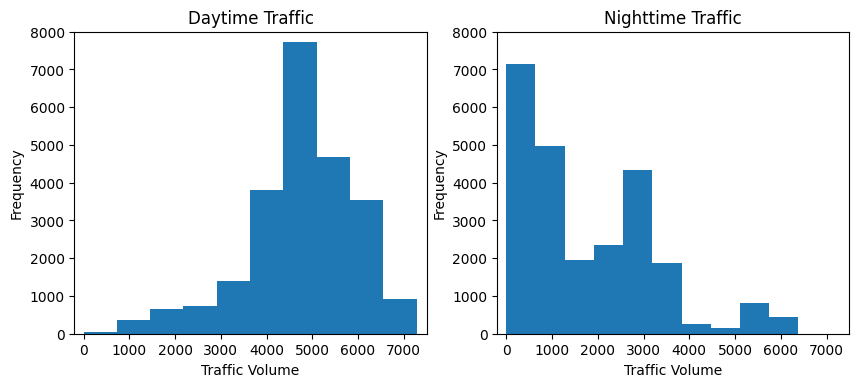

In [50]:
# Plot the daytime and nighttime histograms side-by-side
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.hist(traffic_daytime["traffic_volume"])
plt.title("Daytime Traffic")
plt.xlabel("Traffic Volume")
plt.ylabel("Frequency")
plt.xlim(-200,7500)
plt.ylim(0,8000)
plt.subplot(1, 2, 2)
plt.hist(traffic_nighttime["traffic_volume"])
plt.title("Nighttime Traffic")
plt.xlabel("Traffic Volume")
plt.ylabel("Frequency")
plt.xlim(-200,7500)
plt.ylim(0,8000)
plt.show()

In [51]:
traffic_daytime["traffic_volume"].describe()

count    23877.000000
mean      4762.047452
std       1174.546482
min          0.000000
25%       4252.000000
50%       4820.000000
75%       5559.000000
max       7280.000000
Name: traffic_volume, dtype: float64

In [52]:
traffic_nighttime["traffic_volume"].describe()


count    24327.000000
mean      1785.377441
std       1441.951197
min          0.000000
25%        530.000000
50%       1287.000000
75%       2819.000000
max       6386.000000
Name: traffic_volume, dtype: float64

The daytime data definitely looks like it's distributed normally, with a skew to the left, showing a tendency towards heavy traffic. 75% of the time, more than 4,252 cars are passing the station per hour.

As for the nighttime data, the bulk of it is located at the lower end of the values, with the mean at less than 30% of the total range (the mean is 1,785, and the range is 0-6,386).

Since the nighttime traffic is mostly light, we'll focus on the daytime traffic from now on.

### Different Time Parameters

- Next, let's look at how different time parameters affect the traffic.

### By Month

- We start by calculating the monthly traffic means:

In [53]:
traffic_daytime['month'] = traffic_daytime['date_time'].dt.month
traffic_by_month = traffic_daytime.groupby('month').mean()
traffic_by_month['traffic_volume']

month
1     4495.613727
2     4711.198394
3     4889.409560
4     4906.894305
5     4911.121609
6     4898.019566
7     4595.035744
8     4928.302035
9     4870.783145
10    4921.234922
11    4704.094319
12    4374.834566
Name: traffic_volume, dtype: float64

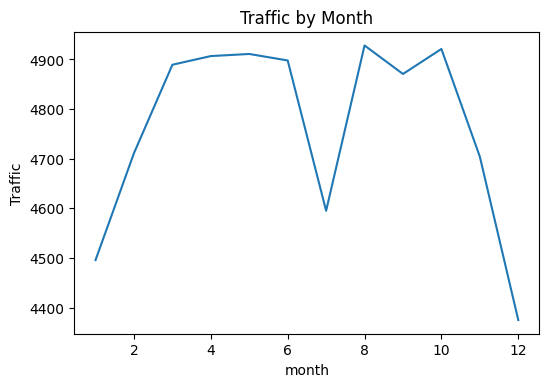

In [54]:
traffic_by_month["traffic_volume"].plot()
plt.title("Traffic by Month")
plt.ylabel("Traffic")
plt.show()

The graph clearly shows that the traffic is highest in the summer months (March-October). It then drops until it reaches a minimum in December, then gradually rises again. There's another, smaller, dip in July. I assume this corresponds to holidays, when fewer people use the highway to get to and from work, or are on holiday elsewhere.

Since I'm not aware of a holiday in July that will cause such a dip in road usage (Independence Day is a single day, and people don't tend to go on holiday during that time), I wanted to check the reason for the dip.

So let's look at the traffic on this month over the years:

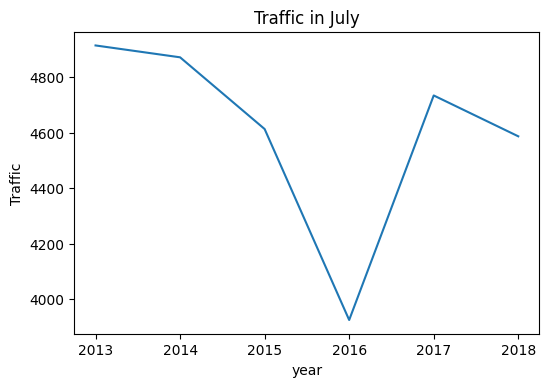

In [55]:
traffic_daytime['year'] = traffic_daytime['date_time'].dt.year
traffic_in_july = traffic_daytime[traffic_daytime['month'] == 7]
traffic_in_july.groupby('year').mean()['traffic_volume'].plot.line()
plt.title("Traffic in July")
plt.ylabel("Traffic")
plt.show()

While there seems to be a slight general trend toward lower traffic over the years, there's a major dip in 2016, after which traffic jumped back up to almost its value 3 years earlier. Could this be due to road closure(s)? Let's compare at the daily traffic in July 2016 to the one in the following year:

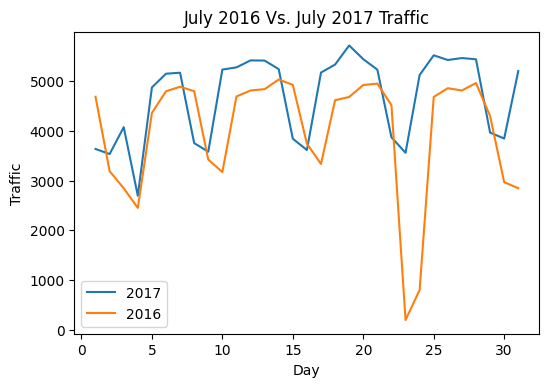

In [56]:
# Get the traffic data for 
traffic_in_july_2016 = traffic_in_july.copy()[traffic_in_july['year'] == 2016]
traffic_in_july_2016['day'] = traffic_in_july['date_time'].dt.day
traffic_in_july_2017 = traffic_in_july.copy()[traffic_in_july['year'] == 2017]
traffic_in_july_2017['day'] = traffic_in_july['date_time'].dt.day


plt.show()

# Plot the mean daily traffic volume in July 2016 and July 2017
plt.plot(traffic_in_july_2017.groupby('day').mean()['traffic_volume'], label="2017")
plt.plot(traffic_in_july_2016.groupby('day').mean()['traffic_volume'], label="2016")
plt.legend()
plt.title("July 2016 Vs. July 2017 Traffic")
plt.xlabel("Day")
plt.ylabel("Traffic")
plt.show()

Comparing both graphs we see that traffic in July 2017 was slightly higher in general than that of the previous year. The slight offset is due to the weekends starting a day earlier in 2017. We see a similar drop around the 4th of July in both years, but nothing between 20 and 25 in 2017. Google tells us that there's been a road closure on the weekend of the 22nd of July 2016, which corresponds with the drop to almost 0 cars around that time.

Since July 2016 is an outlier, let's see how the Traffic by Month data looks like without it. Due to the 4th of July dip we can probably expect the mean July traffic to be slightly lower than the one in the surrounding months.

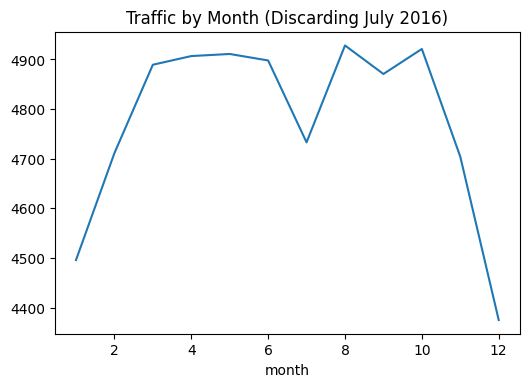

In [57]:
# Remove July 2016 traffic data from the dataset
traffic_daytime = traffic_daytime[(traffic_daytime['month'] != 7) | (traffic_daytime['year'] != 2016)]

# Plot the modified dataset
traffic_by_month = traffic_daytime.groupby('month').mean()
traffic_by_month["traffic_volume"].plot()
plt.title("Traffic by Month (Discarding July 2016)")
plt.show()

The dip in July is lower now, and as we saw it can be explained by the lower traffic on and around 4th of July.

### By Day of Week

Let's do a similar analysis by the day of the week:

In [58]:
traffic_daytime['day_of_week'] = traffic_daytime['date_time'].dt.dayofweek
traffic_by_day_of_week = traffic_daytime.groupby('day_of_week').mean()

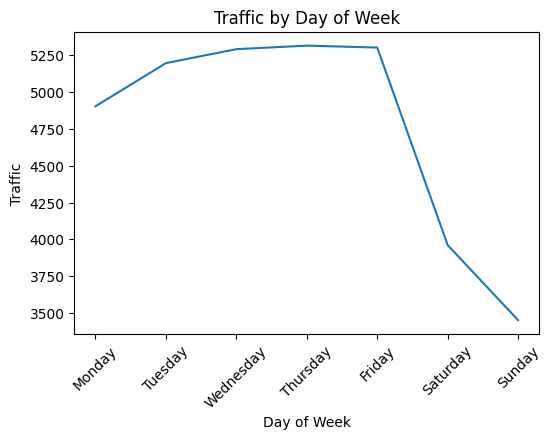

In [59]:
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.plot(traffic_by_day_of_week["traffic_volume"])
plt.xticks(ticks=range(7), labels=day_names, rotation=45)
plt.title("Traffic by Day of Week")
plt.ylabel("Traffic")
plt.xlabel("Day of Week")
plt.show()


As expected, the traffic is heaviest on weekdays. It starts low on Monday, then gets to about 5,300 cars per hour for the rest of the work week, then drops significantly on weekends.

### By Time of Day

Let's see how the time of day affects traffic. Since the usage profile is significantly different between weekdays and weekends I'll look at both ctegories separately.

In [60]:
traffic_daytime['hour'] = traffic_daytime['date_time'].dt.hour
# Take only the work days (Between 0 (Monday) and 4 (Friday))
work_days = traffic_daytime.copy()[traffic_daytime['day_of_week'] <= 4]
# Take only the weekend days
weekend = traffic_daytime.copy()[traffic_daytime['day_of_week'] > 4]

work_days_by_hour = work_days.groupby('hour').mean()
weekend_by_hour = weekend.groupby('hour').mean()

work_days_by_hour['traffic_volume']

hour
7     6037.160468
8     5512.771134
9     4904.646976
10    4384.295516
11    4639.753634
12    4863.640784
13    4867.903153
14    5164.883871
15    5603.860176
16    6199.325714
17    5792.822222
18    4443.330508
Name: traffic_volume, dtype: float64

In [61]:
weekend_by_hour['traffic_volume']

hour
7     1588.243243
8     2341.470389
9     3130.977032
10    3708.916084
11    4085.745856
12    4416.766114
13    4410.101852
14    4388.607076
15    4372.554307
16    4371.000000
17    4177.105263
18    3825.016854
Name: traffic_volume, dtype: float64

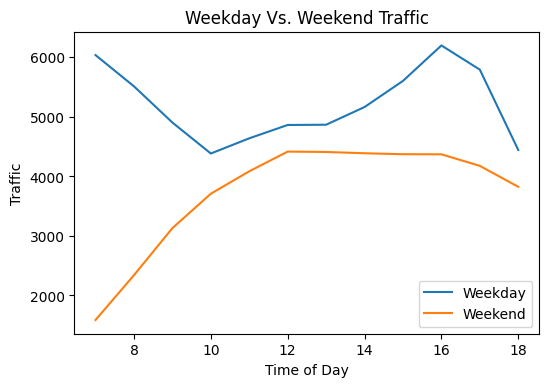

In [62]:
plt.plot(work_days_by_hour['traffic_volume'], label="Weekday")
plt.plot(weekend_by_hour['traffic_volume'], label="Weekend")
plt.legend()
plt.title("Weekday Vs. Weekend Traffic")
plt.xlabel("Time of Day")
plt.ylabel("Traffic")
plt.show()

The graph above clearly shows the difference in workdays and weekend traffic profiles.

Workday traffic has two peaks - around 7 a.m., when people get to work, and around 4 p.m., when they start to head back home, when traffic exceeds 6,000 cars/hour.

Weekend traffic is both lighter and later - it starts low, and gradually rises until it peaks around noon, at less than 4,500 cars/hour. It then plateaus until 4 p.m., when it starts to get lighter. This matches a more relaxed usage profile, of people waking up later, and going about their business throughout the day.


### Effect of Holidays on traffic


In [63]:
traffic_daytime['holiday'].value_counts()

None                         22772
Washingtons Birthday            73
Thanksgiving Day                71
Labor Day                       69
Christmas Day                   69
New Years Day                   67
Memorial Day                    65
State Fair                      60
Veterans Day                    59
Columbus Day                    59
Independence Day                54
Martin Luther King Jr Day       53
Name: holiday, dtype: int64

There are 11 different holidays mentioned in the dataset. Let's check how each holiday affects traffic in general:



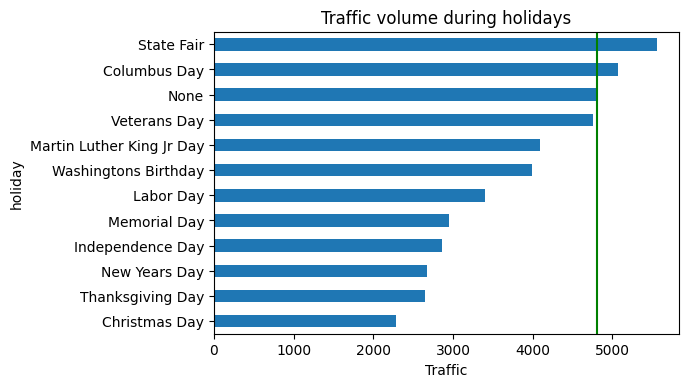

In [64]:
# Group traffic information by each holiday
traffic_by_holiday = traffic_daytime.groupby(traffic_daytime['holiday']).mean()

# display the informataion using a horizontal bar plot
traffic_by_holiday['traffic_volume'].sort_values().plot.barh()
plt.title("Traffic volume during holidays")
plt.xlabel("Traffic")
plt.axvline(x=traffic_by_holiday['traffic_volume']['None'], color='green')
plt.show()

We can see from the bar plot that while most holidays have a negative effect on traffic volume (i.e., traffic is lower during the holiday), there are two holidays that cause heavier traffic - the State Fair and Columbus Day. Why is that?

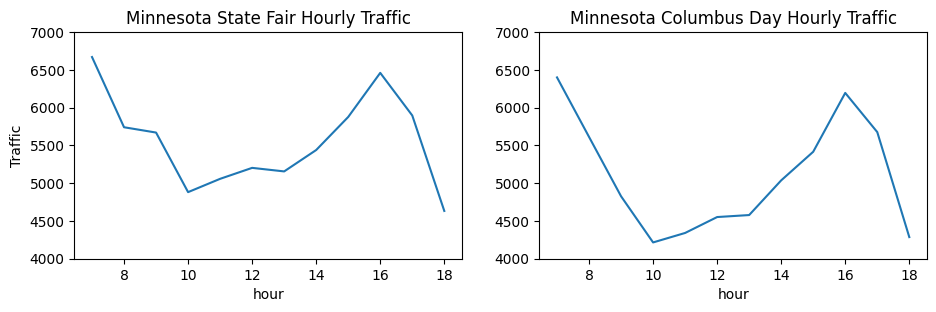

In [65]:
# Get the specific traffic data for both holidays
state_fair_traffic = traffic_daytime[traffic_daytime['holiday'] == "State Fair"]
state_fair_traffic_by_hour = state_fair_traffic.groupby(state_fair_traffic['hour']).mean()
columbus_day_traffic = traffic_daytime[traffic_daytime['holiday'] == "Columbus Day"]
columbus_day_traffic_by_hour = columbus_day_traffic.groupby(columbus_day_traffic['hour']).mean()

# Plot the traffic data of both holidays side by side
plt.figure(figsize=(11,3))
plt.subplot(1, 2, 1)
state_fair_traffic_by_hour['traffic_volume'].plot()
plt.title("Minnesota State Fair Hourly Traffic")
plt.ylabel("Traffic")
plt.ylim(4000, 7000)
plt.subplot(1, 2, 2)
columbus_day_traffic_by_hour['traffic_volume'].plot()
plt.title("Minnesota Columbus Day Hourly Traffic")
plt.ylim(4000, 7000)
plt.show()

Well, traffic on these holidays behaves similarly to that of standard workdays. So I assume from the plots that these holidays aren't state holidays in Minnesota. do they have any effect on traffic? Let's check the mean workday traffic:

In [66]:
workday_traffic_mean = work_days['traffic_volume'].mean()
print(f"Workday traffic: {workday_traffic_mean:.2f}")
print(f"State Fair traffic: {traffic_by_holiday['traffic_volume']['State Fair']:.2f}")
print(f"Columbus Day traffic: {traffic_by_holiday['traffic_volume']['Columbus Day']:.2f}")

Workday traffic: 5200.22
State Fair traffic: 5557.75
Columbus Day traffic: 5073.61


So Columbus Day traffic is actually slightly lower than the average, but State Fair does have a measurable impact on traffic.

### Summary

These are the time-related indicators of heavy traffic:

- Summertime (March-October) traffic is heavier than wintertime (November-February)
- Weekday traffic is heavier than weekend one
- On weekdays, peak hours ar 7-8 a.m. and 4-5 p.m., when people are heading to and from work. On weekends there are no particular peak hours.
- On holidays, traffic is generally lower than the standard weekend traffic, except for holidays that aren't state holidays, where on traffic the impact is lower. When there's a state fair, traffic is somewhat heavier.

### Weather Indicators
- There are several columns in the dataset that hold data about the weather, which may be good indicators for heavy traffic.

### Numerical Weather Data

- Let's see how the traffic correlates with the numerical weather data:

In [67]:
traffic_daytime.corr()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,month,year,day_of_week,hour
temp,1.000000,0.082494,-0.018954,-0.136313,0.145511,0.221962,0.129459,-0.001025,0.162323
rain_1h,0.082494,1.000000,0.007303,0.085761,-0.015327,0.019483,-0.030401,-0.011929,-0.018264
snow_1h,-0.018954,0.007303,1.000000,0.027903,0.000930,0.026842,-0.004421,-0.008835,0.003972
clouds_all,-0.136313,0.085761,0.027903,1.000000,-0.030247,0.000638,-0.030543,-0.044591,0.025362
traffic_volume,0.145511,-0.015327,0.000930,-0.030247,1.000000,-0.021003,-0.000384,-0.415790,0.175938
month,0.221962,0.019483,0.026842,0.000638,-0.021003,1.000000,-0.159328,0.013506,0.008140
year,0.129459,-0.030401,-0.004421,-0.030543,-0.000384,-0.159328,1.000000,-0.012730,-0.003997
day_of_week,-0.001025,-0.011929,-0.008835,-0.044591,-0.415790,0.013506,-0.012730,1.000000,-0.002448
hour,0.162323,-0.018264,0.003972,0.025362,0.175938,0.008140,-0.003997,-0.002448,1.000000


Wer'e only interested in the correlation between traffic volume and the numerical weather data:



In [68]:
traffic_daytime.corr().loc['traffic_volume', ['temp', 'rain_1h', 'snow_1h', 'clouds_all']]


temp          0.145511
rain_1h      -0.015327
snow_1h       0.000930
clouds_all   -0.030247
Name: traffic_volume, dtype: float64

Seems like the only significant correlation may be with the temperature. The other correlations are just too small. Let's visualise that correlation:

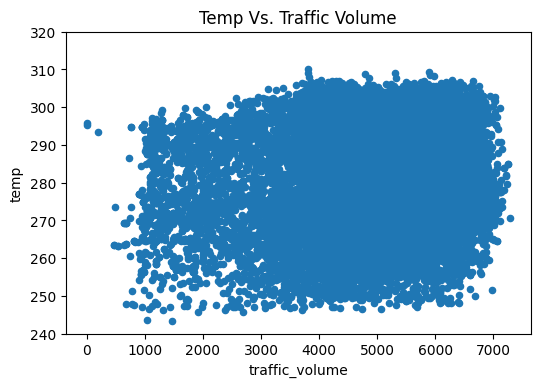

In [69]:
traffic_daytime.plot.scatter('traffic_volume', 'temp')
plt.ylim(240, 320) # Removed a couple of false measurements
plt.title('Temp Vs. Traffic Volume')
plt.show()

This scatter plot doesn't really tell us anything about the correlation between the temperature and traffic volume. It seems that the effect of temperature on traffic is insignificant relative to other factors. So, numerical weather data is not a reliable indicator of traffic in this dataset.

### Categorical Weather Data

- If not numerical, perhaps the categorical weather columns can provide some good data:

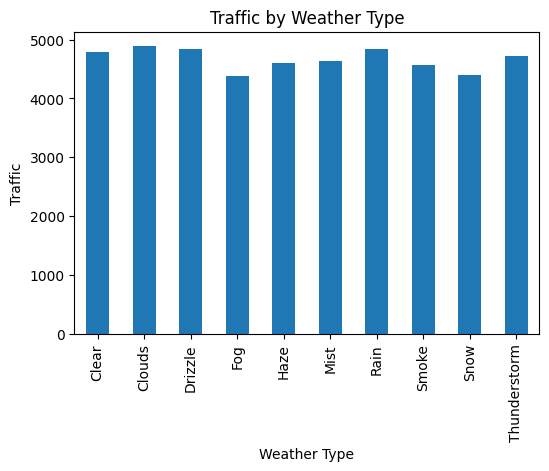

In [71]:
traffic_by_weather_main = traffic_daytime.groupby('weather_main').mean()
traffic_by_weather_desc = traffic_daytime.groupby('weather_description').mean()

traffic_by_weather_main['traffic_volume'].plot.bar()
plt.title("Traffic by Weather Type")
plt.ylabel("Traffic")
plt.xlabel("Weather Type")
plt.show()

From the bar plot we can see that some weather types may cause a small drop in traffic (e.g. fog, snow, smoke), but no type indicates heavy traffic.

What about the weather description?

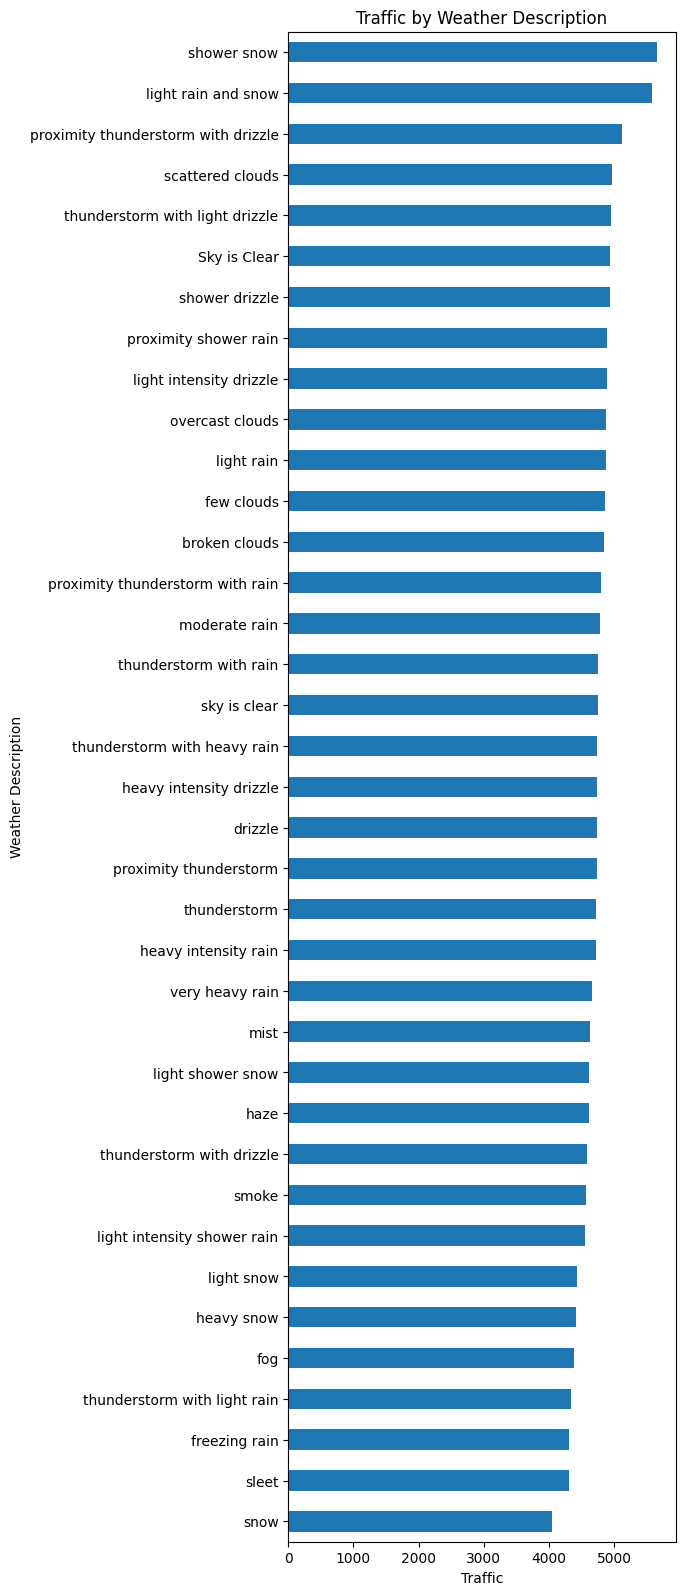

In [72]:
traffic_by_weather_desc['traffic_volume'].sort_values().plot.barh(figsize=(5, 20))
plt.title("Traffic by Weather Description")
plt.xlabel("Traffic")
plt.ylabel("Weather Description")
plt.show()

Two descriptions stand out as possible indicators for heavy traffic - shower snow, and light rain and snow, and to a lesser extent, Proximity thunderstorm with drizzle.

### Conclusion
In this project we practiced using various visualisation methods to help us explore the data. We looked at the westbound traffic data on the I-94 road and tried finding indicators for heavy traffic. We found that heavy traffic correlates with:

- Time of day during workdays (it peaks at 7-8 a.m. and 4-5 p.m.)
- Day of week (there's heavier traffic on work days)
- Month (traffic is heavier during the warmer months of March-October)
- Special Event (During the State Fair traffic is heavier than normal)
- Specific weather ('shower snow', 'light rain and snow' and 'Proximity thunderstorm with drizzle' cause heavier traffic)

### Further Work

- In the project we didn't analyse nighttime traffic data, since nighttime traffic on the I-94 is mostly light. However, even during nighttime traffic can reach more than 6,000 cars/hour, so it may be worthwhile investigating the reasons for it.
